# Flow fitting
Use flow sensors' data (ground truth), HERE speed records, and OSM data to compute the estimated flow.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
import os
import subprocess
import sys
import numpy as np

def get_repo_root():
    """Get the root directory of the repo."""
    dir_in_repo = os.path.dirname(os.path.abspath('__file__')) # os.getcwd()
    return subprocess.check_output('git rev-parse --show-toplevel'.split(),
                                   cwd=dir_in_repo,
                                   universal_newlines=True).rstrip()
sys.path.append(get_repo_root())
ROOT_dir = get_repo_root()

def flow_cal(X, alpha=None, beta=None):
    """
    Function to get flow by using speed, free-flow speed, and capacity
    :param X: an array, [[speed, free-flow speed, capacity]...]
    :param alpha: BPR parameter
    :param beta: BPR parameter
    :return: estimated flow
    """
    return X[:, 2]*((X[:, 1]/X[:, 0] - 1) / alpha)**(1/beta)

In [30]:
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

city='istanbul'
df = pd.read_csv(ROOT_dir + f'/dbs/flow_{city}_m.csv')
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,time,sensor,HERE_segID,flow,speed,osm_id,speed_ff,speed_gt,direction,speed_gt_ff,capacity_gt,oneway,lanes,capacity
0,0,28,3_10128,2295,80.20,76846059,76.0,98.733333,0,112.0,3693.6,1,3,3600
1,1,28,3_10128,2307,80.68,76846059,76.0,98.533333,0,112.0,3693.6,1,3,3600
2,2,28,3_10128,1821,80.63,76846059,76.0,99.814815,0,112.0,3693.6,1,3,3600
3,3,28,3_10128,1431,86.28,76846059,76.0,104.766667,0,112.0,3693.6,1,3,3600
4,4,28,3_10128,1009,89.80,76846059,76.0,106.166667,0,112.0,3693.6,1,3,3600


In [4]:
len(df.loc[df.speed > df.speed_ff, :])/len(df) * 100

34.651019951383795

In [5]:
len(df.loc[df.speed_gt > df.speed, :])/len(df) * 100

81.30540243705659

In [10]:
np.nansum(df.loc[df.speed_gt > df.speed, 'speed_gt'] - df.loc[df.speed_gt > df.speed, 'speed'], )/len(df.loc[df.speed_gt > df.speed, :])

31.54597840057741

## 1. Test a road segment with two functions for its two directions

In [31]:
df = df.loc[(df.speed_gt != 0) & (df.speed_gt_ff > df.speed_gt), :]
r = list(df.groupby(['HERE_segID', 'direction']))
df_road = r[0][1]
df_road.head()

,time,sensor,HERE_segID,flow,speed,osm_id,speed_ff,speed_gt,direction,speed_gt_ff,capacity_gt,oneway,lanes,capacity
2809,0,41,3_10114,2410,80.33,370173491,73.0,77.275862,0,87.6,4590.5,1,3,3600
2810,1,41,3_10114,2387,78.03,370173491,73.0,76.296296,0,87.6,4590.5,1,3,3600
2811,2,41,3_10114,2248,80.23,370173491,73.0,79.300000,0,87.6,4590.5,1,3,3600
2812,3,41,3_10114,1478,84.27,370173491,73.0,82.266667,0,87.6,4590.5,1,3,3600
2813,4,41,3_10114,1008,86.33,370173491,73.0,85.400000,0,87.6,4590.5,1,3,3600


In [32]:
X = df_road.loc[:, ['speed_gt', 'speed_gt_ff', 'capacity_gt']].values
y = df_road.flow.values
popt, _ = curve_fit(flow_cal, X, y)
r2 = r2_score(y, flow_cal(X, *popt))

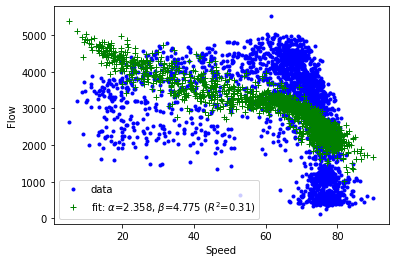

In [33]:
plt.plot(df_road.speed, y, 'b.', label='data')
plt.plot(df_road.speed, flow_cal(X, *popt), 'g+',
         label="fit: $\\alpha$=%5.3f, $\\beta$=%5.3f ($R^2$=%3.2f)" % tuple([x for x in popt] + [r2]))
plt.xlabel('Speed')
plt.ylabel('Flow')
plt.legend()
plt.show()


## 2. Iterate over road segment x direction

In [38]:
df_list = []
params = []
for ele in r:
    # Take a road seg direction to fit with the model
    t = ele[1]
    X = t.loc[:, ['speed_gt', 'speed_gt_ff', 'capacity_gt']].values
    y = t.flow.values
    popt, _ = curve_fit(flow_cal, X, y, bounds=[(0.01, 1), (10, 10)])
    y_fit = flow_cal(X, *popt)
    r2 = r2_score(y, y_fit)
    t.loc[:, 'flow_fit'] = y_fit
    df_list.append(t)
    params.append(tuple([x for x in ele[0]] + [x for x in popt] + [r2]))
df_n = pd.concat(df_list)
df_para = pd.DataFrame(params, columns=['HERE_segID', 'direction', 'alpha', 'beta', 'r2'])
df_n.head()

,time,sensor,HERE_segID,flow,speed,osm_id,speed_ff,speed_gt,direction,speed_gt_ff,capacity_gt,oneway,lanes,capacity,flow_fit
2809,0,41,3_10114,2410,80.33,370173491,73.0,77.275862,0,87.6,4590.5,1,3,3600,2516.256111
2810,1,41,3_10114,2387,78.03,370173491,73.0,76.296296,0,87.6,4590.5,1,3,3600,2571.338818
2811,2,41,3_10114,2248,80.23,370173491,73.0,79.300000,0,87.6,4590.5,1,3,3600,2390.866669
2812,3,41,3_10114,1478,84.27,370173491,73.0,82.266667,0,87.6,4590.5,1,3,3600,2162.668098
2813,4,41,3_10114,1008,86.33,370173491,73.0,85.400000,0,87.6,4590.5,1,3,3600,1782.594563


In [39]:
# Check the parameters
df_para.head()

,HERE_segID,direction,alpha,beta,r2
0,3_10114,0,2.358394,4.775112,0.313288
1,3_10114,1,2.331907,5.055983,0.398671
2,3_10116,0,5.321872,5.244585,0.479993
3,3_10116,1,2.888690,3.591069,0.536621
4,3_10118,0,3.217075,3.600951,0.721100


In [43]:
len(df_para.loc[df_para.r2 >0, :]) / len(df_para)
df_para.to_csv(ROOT_dir + f'/results/{city}_params.csv', index=False)
df_n.to_csv(ROOT_dir + f'/dbs/flow_{city}_m_estimated.csv', index=False)

## 3. Find a single parameter set for all

In [42]:
# Take a road seg direction to fit with the model
X = df.loc[:, ['speed_gt', 'speed_gt_ff', 'capacity_gt']].values
y = df.flow.values
popt, _ = curve_fit(flow_cal, X, y, bounds=[(0.01, 1), (10, 10)])
y_fit = flow_cal(X, *popt)
r2 = r2_score(y, y_fit)
mse = mean_squared_error(y, y_fit)
df.loc[:, 'flow_fit'] = y_fit
print("Parameters:", tuple([x for x in popt] + [r2, mse]))

Parameters: (5.629002692923951, 5.1629315009731656, 0.4284014153939376, 1406325.0328355886)
